In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from matplotlib.pylab import rcParams
%matplotlib inline

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_X, _), (test_x, _) = cifar10.load_data()

train_X.shape

(50000, 32, 32, 3)

In [3]:
print('train_X의 max pixel:', train_X.max())
print('train_X의 min pixel:', train_X.min())

train_X의 max pixel: 255
train_X의 min pixel: 0


In [4]:
train_x = (train_X-127.5) / 127.5
print(train_x.max())
print(train_x.min())

1.0
-1.0


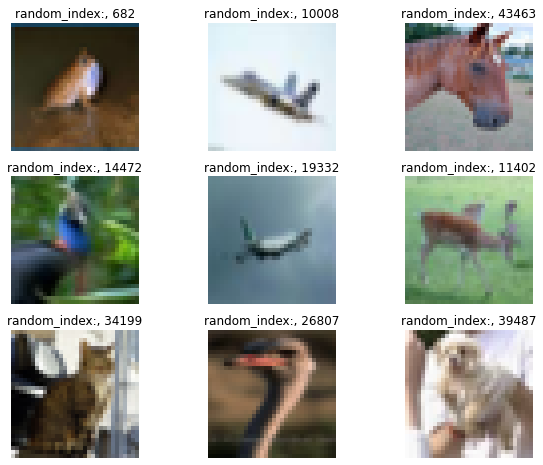

In [5]:
plt.figure(figsize=(10,8))

for i in range(9):
    plt.subplot(3, 3, i+1)
    rand_index = np.random.randint(1, 50000)
    plt.imshow(train_X[rand_index].reshape(32, 32, 3))
    plt.title(f'random_index:, {rand_index}')
    plt.axis('off')
plt.show()

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First. Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second, Reshape layer
    model.add(layers.Reshape((4,4,256)))
    
    # Third. Cnv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # 4th. Cnv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # 5th. Cnv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
        
    # 6th. Cnv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same', 
                                     use_bias=True, activation='tanh'))
    
    return model

# define model
generator = generator_model()
# summarize the model
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [8]:
from tensorflow.keras.optimizers import Adam

def discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # 1st. Conv2D Layer
    model.add(layers.Conv2D(64,(3,3),  padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # 2nd. Conv2D Layer
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 3rd. Conv2D Layer
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 4th. Conv2D Layer
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 5th. Flatten Layer
    model.add(layers.Flatten())
    
    # 6th. Dense Layer
    model.add(layers.Dense(1))
    
    return model

# define model
discriminator = discriminator_model()
# summarize the model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [9]:
from tensorflow import math

def generator_loss(fake_output):
    return -math.reduce_mean(fake_output)

In [10]:
def discriminator_loss(real_output, fake_output):
    total_loss = -math.reduce_mean(real_output) + math.reduce_mean(fake_output)
    return total_loss

In [11]:
def discriminator_accuracy(real_output, fake_output):
    # 벡터의 각 원소가 0.5 이상이면 True, True라면 1.0으로 반환
    # 이후, 결과를 평균내어 배치의 정확도 계산
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output,
                                                                tf.constant([0.5])),
                                          tf.float32))
    # 벡터의 각 원소가 0.5 이하면 True, True라면 1.0으로 반환
    # 이후 결과를 평균내어 배치의 정확도 계산
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output,
                                                       tf.constant([0.5])),
                                          tf.float32))
    return real_accuracy, fake_accuracy

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
num_ex_generated = 16
noise_dim = 100

seed = tf.random.normal([num_ex_generated, noise_dim])
seed.shape

TensorShape([16, 100])

In [14]:
@tf.function
def train_step(images): # Real_image 역할을 할 Images 한 세트를 입력 받음
    # 생성자가 fake_image를 생성하기 위한 noise images 생성
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        # 생성자가 noise를 입력받은 후 generated_images 생성
        generated_images = generator(noise, training=True)
        
        # 판별자가 images(실사)와 generated_images를 각각 입력받은 후,
        # real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # real_output과 fake_output으로 생성자와 판별자 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)
        
        # real_output과 fake_output으로 판별자의 accuracy계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
        # Gradient 계산. gen_tape과 dis_tape을 활용해 gradient 자동계산
        grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        grad_discriminator = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
        
        # 모델 학습. 계산된 gradient를 optimizer에 입력해 가중치 갱신
        generator_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))
        
        return gen_loss, dis_loss, real_accuracy, fake_accuracy

In [15]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    
    fig=plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]): # 16
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_3/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
               .format(os.getenv('HOME'), epoch, it))
    plt.show()

In [16]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['dis_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'dis_loss'], loc='upper left')
    
    # accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # epoch별 그래프 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_3/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()   

In [17]:
checkpoint_dir = './cifar10_3/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                             discriminator_optimizer = discriminator_optimizer,
                             generator = generator,
                             discriminator = discriminator)

In [18]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss' : [], 'dis_loss' : [], 'real_accuracy' : [], 'fake_accuracy' : []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, dis_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['dis_loss'].append(dis_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 200 ==0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)                

In [19]:
save_every = 10
EPOCHS = 700

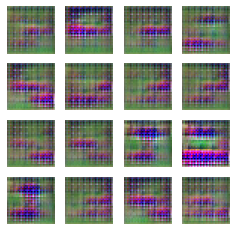

Time for training : 25379 sec


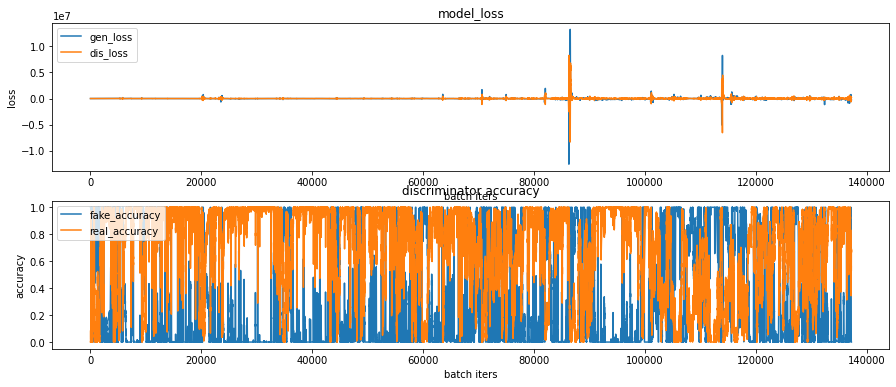

CPU times: user 7h 2min 27s, sys: 15min 5s, total: 7h 17min 32s
Wall time: 7h 3min 6s


In [20]:
%%time
train(train_dataset, EPOCHS, save_every)